In [72]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import trompy as tp

import dill

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

In [73]:
with open(DATAFOLDER / "x_array.pickle", "rb") as f:
    x_array = dill.load(f)

In [74]:
x_array

,trial,id,condition,infusiontype,cluster
0,0,PB23,deplete,10NaCl,0
1,1,PB23,deplete,10NaCl,0
2,2,PB23,deplete,10NaCl,0
3,3,PB23,deplete,10NaCl,1
4,4,PB23,deplete,10NaCl,0
...,...,...,...,...,...
2797,44,PB31,thirsty,45NaCl,1
2798,45,PB31,thirsty,45NaCl,1
2799,46,PB31,thirsty,45NaCl,1
2800,47,PB31,thirsty,45NaCl,1


In [75]:
(df
 .query("condition == 'thirsty'")
 .groupby("cluster").count()
)

,trial,id,condition,infusiontype
cluster,,,,
0,38,38,38,38
1,30,30,30,30
2,77,77,77,77
3,38,38,38,38
4,26,26,26,26
5,35,35,35,35
6,30,30,30,30
7,32,32,32,32
8,37,37,37,37


Analyzing deplete 10NaCl
Analyzing replete 10NaCl
Analyzing replete_exp 10NaCl
Analyzing thirsty 10NaCl
Analyzing deplete 45NaCl
Analyzing replete 45NaCl
Analyzing replete_exp 45NaCl
Analyzing thirsty 45NaCl


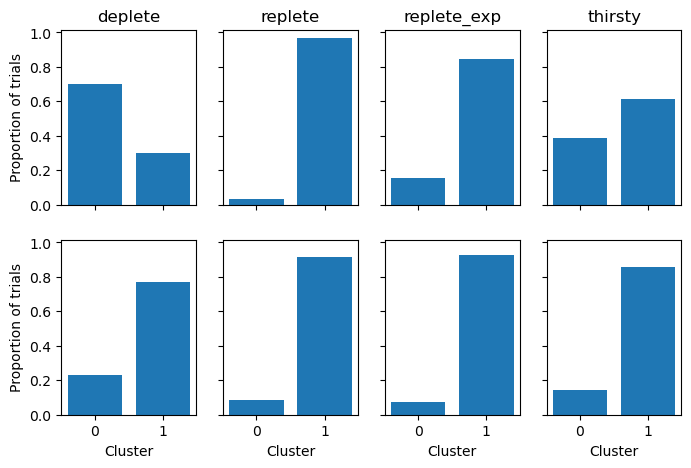

In [77]:
infusiontype = "10NaCl"

df = x_array
n_clusters = len(df.cluster.unique())

f, ax = plt.subplots(ncols=4, nrows=2,
                     figsize=(8, 5),
                     sharey=True, sharex=True)
barx=np.arange(n_clusters)

for row, infusiontype in enumerate(df.infusiontype.unique()):
    for col, condition in enumerate(df.condition.unique()):
        print("Analyzing", condition, infusiontype)
        df_temp = df.query("condition == @condition & infusiontype == @infusiontype")
        data_to_plot = (df_temp
                        .groupby("cluster")
                        .count()
                        .infusiontype
                        .to_list()
        )
        data_to_plot_as_proportion = data_to_plot / np.sum(data_to_plot)
        ax[row,col].bar(barx, data_to_plot_as_proportion)
        # df_condition = df.query("condition == @condition")
        # df_condition = df_condition.sort_values("infusionrate")
        # #plt.plot(df_condition.infusionrate, df_condition.mean, label=condition)
        
    
ax[0,0].set_title("deplete")
ax[0,1].set_title("replete")
ax[0,2].set_title("replete_exp")
ax[0,3].set_title("thirsty")

for axis in ax[1]:
    axis.set_xticks(barx)
    axis.set_xlabel("Cluster")
    
    
for axis in [ax[0,0], ax[1,0]]:
    axis.set_ylabel("Proportion of trials")

In [78]:
with open(DATAFOLDER / "snips_data.pickle", "rb") as f:
    data = dill.load(f)

snips_10NaCl = data["snips_10NaCl"]
snips_45NaCl = data["snips_45NaCl"]
# x_10NaCl = data["x_10NaCl"]
# x_45NaCl = data["x_45NaCl"]

In [79]:
snips_all = np.vstack([snips_10NaCl, snips_45NaCl])

In [80]:
snips_all.shape

(2802, 200)

Cluster 0
(663, 200)
Cluster 1
(2139, 200)


Text(0, 0.5, 'dF/F')

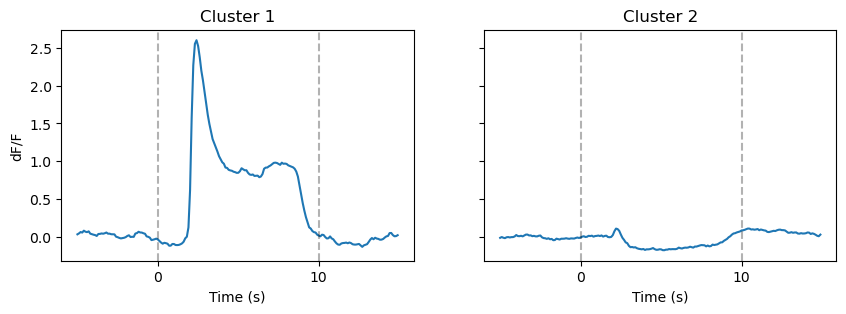

In [81]:
f, ax = plt.subplots(ncols=len(x_array.cluster.unique()), sharey=True, figsize=(10, 3))

for cluster in x_array.cluster.unique():
    print("Cluster", cluster)
    snips_cluster = snips_all[x_array.cluster == cluster, :]
    
    print(snips_cluster.shape)
    ax[cluster].plot(np.mean(snips_cluster, axis=0))
    ax[cluster].set_title(f"Cluster {cluster+1}")

for axis in ax:
    axis.set_xlabel("Time (s)")
    axis.set_xticks([50, 150], labels = ["0", "10"])
    axis.axvline(50, color="k", linestyle="--", alpha=0.3)
    axis.axvline(150, color="k", linestyle="--", alpha=0.3)
    
ax[0].set_ylabel("dF/F")

In [82]:
df = x_array

def get_prop_of_cluster(df, cluster, condition, infusiontype):
    df_temp = (df
               .query("condition == @condition & infusiontype == @infusiontype")
               )
               
    prop_by_trial = []

    for trial in df_temp.trial.unique():
        n = len(df_temp.query("trial == @trial"))
        n_cluster = len(df_temp.query("trial == @trial & cluster == @cluster"))
        prop_by_trial.append(n_cluster / n)
    
    return prop_by_trial

p = get_prop_of_cluster(df, 0, "thirsty", "45NaCl")

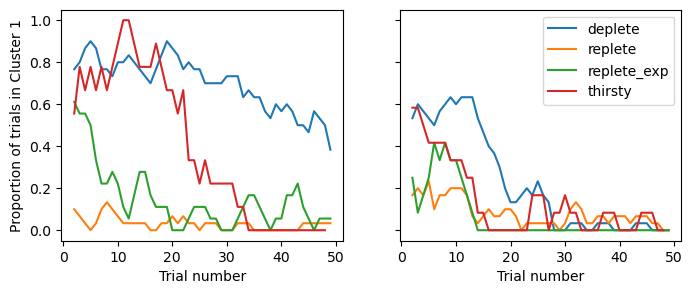

In [83]:
df = x_array

f, ax = plt.subplots(ncols=2, figsize=(8, 3), sharey=True)

cluster=0

infusiontype = "10NaCl"
for condition in df.condition.unique():
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[0].plot(df_to_plot.rolling, label=f"{condition} cluster {cluster}")
        
infusiontype = "45NaCl"
for condition in df.condition.unique():
        prop_by_trial = get_prop_of_cluster(df, cluster, condition, infusiontype)
        df_to_plot = pd.DataFrame({"prop": prop_by_trial})
        df_to_plot.rolling = df_to_plot.prop.rolling(window=3).mean()
        ax[1].plot(df_to_plot.rolling, label=condition)
        
ax[1].legend()

ax[0].set_ylabel("Proportion of trials in Cluster 1")

for axis in ax:
        axis.set_xlabel("Trial number")
        #axis.set_ylim(0, 1)